# This notebook is a demonstration of running the combined peak ranging and peak ion identification ML models

Ryan Jacobs, based on original code from Jingrui Wei

Last updated: 5/5/25 by Ryan Jacobs


# Install and setup for Google Colab

In [1]:
# Link Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Clone repo

!git clone https://github.com/uw-cmg/peak_detection

Cloning into 'peak_detection'...
remote: Enumerating objects: 572, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 572 (delta 56), reused 32 (delta 11), pack-reused 449 (from 1)
Receiving objects: 100% (572/572), 57.45 MiB | 27.63 MiB/s, done.
Resolving deltas: 100% (302/302), done.


In [3]:
# Install dependencies. Annoyingly takes about 5 minutes.

!pip install -r "peak_detection/requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 MB 15.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of lmfit to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [1]:
# For Colab, move repo directories so imports work

import shutil
shutil.move('peak_detection', 'peak_detection_repo')
shutil.move('peak_detection_repo/peak_detection', '.')

'./peak_detection'

# Import needed packages

In [2]:
!pip install pymatgen
!pip install numpy==1.23.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.0/809.0 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 39.1 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=43549 sha256=959fdc36a1039bc92d551e0ada87c350d75f3f6cb3327d990589b718c89ac062
  Stored in directory: /root/.cache/pip/wheels/16/fb/76/306387739cf9d53b1c39b0c8

In [1]:
import apav
import os
import peak_detection
from peak_detection.RangingNN.predictor import DetectionPredictor
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.signal import find_peaks
from sklearn.preprocessing import LabelEncoder
import yaml
from pathlib import Path
import torch.nn.functional as F
import joblib
import matplotlib.colors as mcolors
from pymatgen.core import Composition
import pandas as pd

# Function definitions to do model predictions and visualization

In [48]:
def map01(ar):
    return (ar-ar.min()) / (ar.max()-ar.min())

def load_apt(apt_file):
    '''

    '''
    # Load the .apt file and get histogram
    d = apav.load_apt(apt_file)
    x, spectrum = d.mass_histogram(bin_width=0.01, lower=0, upper=307.2, multiplicity='all', norm=False,)
    spectrum_log = torch.tensor(map01(np.log(spectrum+1)), dtype=torch.float32)
    return spectrum, spectrum_log

def sort_predictions(peak_range_pred, elements):
    peak_range_pred_sort = peak_range_pred[peak_range_pred[:, 0].argsort()]
    inds = list(peak_range_pred[:, 0].argsort())
    inds = [int(i) for i in inds]
    elements_sort = [elements[i] for i in inds]
    return peak_range_pred_sort, elements_sort

def get_label_encoder():
    '''

    '''

    CHEMICAL_ELEMENTS = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al',
                         'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe',
                         'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr',
                         'Y', 'Zr', 'Nb', 'Mo', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb',
                         'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd',
                         'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir',
                         'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Th', 'U']

    le = LabelEncoder()
    le.fit(CHEMICAL_ELEMENTS)
    return le

def get_RF_encoder(reduced_set=False):
    if reduced_set == False:
        target_decoder = {0: 'Ag', 1: 'Al', 2: 'Ar', 3: 'As', 4: 'Au', 5: 'B', 6: 'Ba',
                          7: 'Be', 8: 'Bi', 9: 'Br', 10: 'C', 11: 'Ca', 12: 'Cd', 13: 'Ce',
                          14: 'Cl', 15: 'Co', 16: 'Cr', 17: 'Cs', 18: 'Cu', 19: 'Dy', 20: 'Er',
                          21: 'Eu', 22: 'F', 23: 'Fe', 24: 'Ga', 25: 'Gd', 26: 'Ge', 27: 'H',
                          28: 'He', 29: 'Hf', 30: 'Hg', 31: 'Ho', 32: 'I', 33: 'In', 34: 'Ir',
                          35: 'K', 36: 'Kr', 37: 'La', 38: 'Li', 39: 'Lu', 40: 'Mg', 41: 'Mn',
                          42: 'Mo', 43: 'N', 44: 'Na', 45: 'Nb', 46: 'Nd', 47: 'Ni', 48: 'O',
                          49: 'Os', 50: 'P', 51: 'Pb', 52: 'Pd', 53: 'Pr', 54: 'Pt', 55: 'Rb',
                          56: 'Re', 57: 'Rh', 58: 'Ru', 59: 'S', 60: 'Sb', 61: 'Sc', 62: 'Se',
                          63: 'Si', 64: 'Sm', 65: 'Sn', 66: 'Sr', 67: 'Ta', 68: 'Tb', 69: 'Te',
                          70: 'Th', 71: 'Ti', 72: 'Tl', 73: 'Tm', 74: 'U', 75: 'V', 76: 'W',
                          77: 'Xe', 78: 'Y', 79: 'Zn', 80: 'Zr'}
    else:
        target_decoder = {0: 'Ag', 1: 'Al', 2: 'Au', 3: 'C', 4: 'Ca', 5: 'Co', 6: 'Cu',
                          7: 'Fe', 8: 'Ga', 9: 'H', 10: 'Li', 11: 'Mg', 12: 'Mn', 13: 'Na',
                          14: 'Ni', 15: 'O', 16: 'Pd', 17: 'Pt', 18: 'S', 19: 'Sc', 20: 'Si',
                          21: 'Ti', 22: 'Zn', 23: 'Zr'}
    return target_decoder

def predict_elements(model, spectrum, label_encoder, device):
    '''

    '''
    model.eval()
    with torch.no_grad():
        spectrum = torch.FloatTensor(spectrum).unsqueeze(0).to(device)
        outputs = model(spectrum, lengths = [spectrum.shape[1]])

        probabilities = F.softmax(outputs, dim=2)
        predictions = torch.argmax(outputs, dim=2)

        # Convert numerical predictions to element names
        element_predictions = label_encoder.inverse_transform(predictions.cpu().numpy().ravel())
        confidence_scores = torch.max(probabilities, dim=2)[0].cpu().numpy().ravel()

        return element_predictions, confidence_scores

def plot_predictions(apt_file, peak_range_pred, res, confidence, plot_min=0, plot_max=20000, resort=True, res2=None, confidence2=None):
    '''
    plot_max : # in 0.01 Da
    '''
    plt.clf()
    spectrum, spectrum_log = load_apt(apt_file=apt_file)

    # set the zoom in m/c range
    bin_width = 0.01
    peak_pred_ = peak_range_pred[(peak_range_pred[:,0] < plot_max) & (peak_range_pred[:,0] >plot_min)]

    # Create the plot
    fig, ax = plt.subplots(figsize=(7, 4))

    # Plot the spectrum
    x = 0.01 * torch.linspace(plot_min,plot_max, plot_max - plot_min)

    ax.plot(x[...,None], spectrum_log[..., plot_min:plot_max].T, 'k-', linewidth=1)

    # Add color boxes for each peak range
    # Add vertical lines to show the boundaries of ranges

    for start, end in peak_pred_:
        ax.axvspan(start*0.01, end*0.01, alpha=0.3, color='red',label='Model prediction' if start == peak_pred_[0][0] else "")
    for start, end in peak_pred_:
        ax.axvline(start*0.01, color='red', linestyle='--', alpha=0.7, lw = 0.7)
        ax.axvline(end*0.01, color='red', linestyle='--', alpha=0.7, lw = 0.7)

    # Set labels and title
    ax.set_xlabel('Mass to charge ratio (Da)')
    ax.set_ylabel('Intensity in log scale normalized (counts)')

    ax.set_xlim(-2, 0.01*plot_max)

    # Add the predicted ions and their confidences
    if resort == True:
        peak_range_pred = peak_range_pred[peak_range_pred[:, 0].argsort()][:, 0]
    else:
        peak_range_pred = peak_range_pred[:, 0]
    #for peak_start, ion, conf in zip(peak_range_pred[:,0], res, confidence):
    if res2 is not None:
        for peak_start, ion, conf, ion2, conf2 in zip(peak_range_pred, res, confidence, res2, confidence2):
            if peak_start < plot_max:
                y_rand = np.random.uniform(low=0.5, high=1.0)
                ax.text(0.01*float(peak_start)+0.02, y_rand, ion+':'+str(round(conf,2)))
                if conf2 > 0.0:
                    ax.text(0.01*float(peak_start)+0.02, y_rand-0.05, ion2+':'+str(round(conf2,2)), color='blue')
    else:
        for peak_start, ion, conf in zip(peak_range_pred, res, confidence):
            if peak_start < plot_max:
                y_rand = np.random.uniform(low=0.5, high=1.0)
                ax.text(0.01*float(peak_start)+0.02, y_rand, ion+':'+str(round(conf,2)))

    # Adjust the plot layout
    plt.tight_layout()
    plt.legend()
    fname = apt_file.split('/')[-1]
    plt.savefig(fname+'_ranging_ion_preds.png', dpi=350, bbox_inches='tight')

    return

def predict_peak_ranges(apt_file, conf=0.02, iou=0.01, max_det=2000):
    '''

    '''

    spectrum, spectrum_log = load_apt(apt_file=apt_file)

    # Load in the RangingNN model and do the peak detection
    cfg = os.path.dirname(peak_detection.__file__) + '/RangingNN/cfg/prediction_args.yaml' # loading the default parameter file in the package
    cfg = yaml.safe_load(Path(cfg).read_text())

    cfg['iou'] = iou
    cfg['conf'] = conf
    cfg['max_det'] = max_det

    modelpath = os.path.join(os.path.dirname(peak_detection.__file__), 'RangingNN/modelweights/best.pt') # loading the default trained-model in the package
    predictor = DetectionPredictor(modelpath, spectrum_log[None, None, ...], save_dir = 'test_results', cfg = cfg)
    result = predictor()[0]
    peak_range_pred = result[:,:2].cpu()
    counts = result[:,2].cpu()

    print('model predicted peaks:',peak_range_pred.shape[0])

    return peak_range_pred, counts

def predict_peak_ions_NN(apt_file, peak_range_pred, bin_width=0.01, max_width_Da=0.5):
    '''
    Certain wide ranges due to the tail leads to over-high indensity,
    shrinking the other intensities, so set limit here
    '''

    spectrum, spectrum_log = load_apt(apt_file=apt_file)

    profile = np.zeros_like(peak_range_pred)
    peak_range_pred = np.asarray(peak_range_pred)

    # Preprocess detected peak ranging data for IonClassifier model
    for k in range(profile.shape[0]):
        profile[k][0] = spectrum[round(peak_range_pred[k][0]):round(peak_range_pred[k][1])+1].argmax()
        profile[k][0] = (profile[k][0] + round(peak_range_pred[k][0]))/100

        window = min(max_width_Da/bin_width, round(peak_range_pred[k][1])+1-round(peak_range_pred[k][0]))
        profile[k][1] = spectrum[round(peak_range_pred[k][0]):round(peak_range_pred[k][0]+window)].sum()

    profile[:,1] = (profile[:,1] - profile[:,1].min() ) / (profile[:,1].max() - profile[:,1].min()) # normalize counts from one spectrum to 0-1

    # Make sure the profile is in sequential order, increasing m/c
    profile_final = profile[profile[:, 0].argsort()]

    # Run the IonClassifier model to predict the peak IDs
    model_path = os.path.join(os.path.dirname(peak_detection.__file__), 'Ionclassifier/modelweights')
    RNNmodel = torch.load(os.path.join(model_path, 'model_bestepoch.tar'), map_location='cpu')['ema']
    le = get_label_encoder()
    res, confidence = predict_elements(RNNmodel, profile_final, le, 'cpu')

    return res, confidence, profile_final

def predict_peak_ions_RF(peak_range_pred, counts, model_name='original'):
    '''
    Use in-development Random forest model for ion peak IDs

    model_name = 'original' or 'reducedset_peakneighbors2' or 'reducedset'
    '''

    if model_name == 'original':
        reduced_set=False
        scaler_path = 'peak_detection_extra/randomforest/StandardScaler.pkl'
        model_path = 'peak_detection_extra/randomforest/RandomForestClassifier.pkl'
    elif model_name == 'reducedset':
        reduced_set=True
        scaler_path = 'peak_detection_extra/randomforest/StandardScaler_reducedset.pkl'
        model_path = 'peak_detection_extra/randomforest/RandomForestClassifier_reducedset.pkl'
    elif model_name == 'reducedset_peakneighbors2':
        reduced_set=True
        scaler_path = 'peak_detection_extra/randomforest/StandardScaler_reducedset_peakneighbors2.pkl'
        model_path = 'peak_detection_extra/randomforest/RandomForestClassifier_reducedset_peakneighbors2.pkl'
    elif model_name == 'reducedset_peakneighbors5':
        reduced_set=True
        scaler_path = 'peak_detection_extra/randomforest/StandardScaler_reducedset_peakneighbors5.pkl'
        model_path = 'peak_detection_extra/randomforest/RandomForestClassifier_reducedset_peakneighbors5.pkl'

    scaler = joblib.load(scaler_path)
    model = joblib.load(model_path)

    X_0 = 0.01*peak_range_pred[:, 0]
    X_1 = counts

    # If using model with peakneighbors2, there are numerous peak ratio features that need to be built
    if model_name == 'reducedset_peakneighbors2' or model_name == 'reducedset_peakneighbors5':
        # Build the features
        # X_0 = m/c, X_1 = counts
        if model_name == 'reducedset_peakneighbors2':
            peak_ratio_neighbor_width = 2
            max_peaks = 13
        elif model_name == 'reducedset_peakneighbors5':
            peak_ratio_neighbor_width = 5
            max_peaks = 21
        ratios = list()
        for i, count1 in enumerate(X_1):
            ratio_row = list()
            for j, count2 in enumerate(X_1):
                ratio = count1 / count2
                dist = abs(X_0[j] - X_0[i])
                if dist <= peak_ratio_neighbor_width:
                    ratio_row.append(ratio)
            ratios.append(ratio_row)
        # Pad the ratio rows
        for i, lst in enumerate(ratios):
            while len(ratios[i]) < max_peaks:
                ratios[i].append(-10000000)
        X = np.column_stack((X_0, X_1, ratios))
    else:
        X = np.column_stack((X_0, X_1))

    print(X.shape)
    print(X)

    X_norm = scaler.transform(X)

    preds = model.predict_proba(X_norm)

    target_decoder = get_RF_encoder(reduced_set=reduced_set)

    elements = list()
    second_elements = list()
    confs = list()
    second_confs = list()
    for pred in preds:
        element = target_decoder[pred.argsort()[-1]]
        conf = pred[pred.argsort()[-1]]
        elements.append(element)
        confs.append(conf)

        second_element = target_decoder[pred.argsort()[-2]]
        second_conf = pred[pred.argsort()[-2]]
        if second_conf > 0.0:
          second_elements.append(second_element)
        else:
          second_elements.append('NaN')
        second_confs.append(second_conf)

    return elements, second_elements, confs, second_confs

def plot_predictions_NEW(apt_file, peak_range_pred, res, confidence, plot_min=0, plot_max=20000, resort=True, res2=None, confidence2=None):
    '''
    plot_max : # in 0.01 Da
    '''
    colors = list(mcolors.TABLEAU_COLORS.values())
    color_inds = [int(np.random.uniform(0, len(colors))) for _ in range(peak_range_pred.shape[0])]

    plt.clf()
    plt.figure(figsize=(10, 6))
    spectrum, spectrum_log = load_apt(apt_file=apt_file)

    x = np.linspace(0.0, spectrum_log.shape[0]*0.01, spectrum_log.shape[0])
    plt.plot(x, spectrum_log)

    # Add color boxes for each peak range
    # Add vertical lines to show the boundaries of ranges

    peak_pred_ = peak_range_pred[(peak_range_pred[:,0] < plot_max) & (peak_range_pred[:,0] > plot_min)]

    count = 0
    for start, end in peak_pred_:
        plt.axvspan(start*0.01, end*0.01, alpha=0.3, color=colors[color_inds[count]])
        plt.axvline(start*0.01, color=colors[color_inds[count]], linestyle='--', alpha=0.7, lw = 0.7)
        plt.axvline(end*0.01, color=colors[color_inds[count]], linestyle='--', alpha=0.7, lw = 0.7)
        count += 1

    # Set labels and title
    plt.xlabel('Mass to charge ratio (Da)')
    plt.ylabel('Intensity in log scale normalized (counts)')

    plt.xlim(0.01*plot_min, 0.01*plot_max)

    # Add the predicted ions and their confidences
    if resort == True:
        peak_range_pred = peak_range_pred[peak_range_pred[:, 0].argsort()][:, 0]
    else:
        peak_range_pred = peak_range_pred[:, 0]
    #for peak_start, ion, conf in zip(peak_range_pred[:,0], res, confidence):
    if res2 is not None:
        for peak_start, ion, conf, ion2, conf2 in zip(peak_range_pred, res, confidence, res2, confidence2):
            if peak_start < plot_max and peak_start > plot_min:
                y_rand = np.random.uniform(low=0.5, high=1.0)
                plt.text(0.01*float(peak_start)+0.02, y_rand, ion+':'+str(round(conf,2)))
                if conf2 > 0.0:
                    plt.text(0.01*float(peak_start)+0.02, y_rand-0.05, ion2+':'+str(round(conf2,2)), color='blue')
                    #plt.text(0.01*float(peak_start)+0.02, 1.0, ion2+':'+str(round(conf2,2)), color='blue')
    else:
        for peak_start, ion, conf in zip(peak_range_pred, res, confidence):
            if peak_start < plot_max and peak_start > plot_min:
                y_rand = np.random.uniform(low=0.5, high=1.0)
                plt.text(0.01*float(peak_start)+0.02, y_rand, ion+':'+str(round(conf,2)))
                #plt.text(0.01*float(peak_start)+0.02, 1.05, ion+':'+str(round(conf,2)))

    # Adjust the plot layout
    plt.tight_layout()
    fname = apt_file.split('/')[-1]
    plt.savefig(fname+'_ranging_ion_preds.png', dpi=350, bbox_inches='tight')

    return

def calculate_iou_1d(interval1, interval2):
    """
    Calculates the Intersection over Union (IoU) of two 1D intervals.

    Args:
        interval1: A tuple or list of two numbers representing the start and end of the first interval.
        interval2: A tuple or list of two numbers representing the start and end of the second interval.

    Returns:
        The IoU of the two intervals, a float between 0 and 1.
    """

    start1, end1 = interval1
    start2, end2 = interval2

    intersection_start = max(start1, start2)
    intersection_end = min(end1, end2)

    intersection_length = max(0, intersection_end - intersection_start)

    union_length = (end1 - start1) + (end2 - start2) - intersection_length

    if union_length == 0:
        return 0.0

    iou = intersection_length / union_length
    return iou

def evaluate_predictions(rng, peak_range_pred_sort, elements_sort, elements_sort2):
    multiplier = 0.01
    iou_thresh = 0.1
    num_found = 0
    num_true = len(rng)
    num_pred = peak_range_pred_sort.shape[0]
    true_elements = list()
    pred_elements = list()
    pred_elements2 = list()
    is_found = list()
    true_found_elements = list()
    true_start = list()
    true_end = list()
    for _, i in enumerate(rng):
        start = i.lower
        end = i.upper
        ious = list()
        true_start.append(start)
        true_end.append(end)
        for __, j in enumerate(peak_range_pred_sort):
            iou = calculate_iou_1d((start, end), (multiplier*float(j[0]), multiplier*float(j[1])))
            ious.append(iou)
        # Find the index with max iou
        iou_max_ind = np.where(np.array(ious)==max(np.array(ious)))[0][0]
        max_iou = ious[iou_max_ind]
        if max_iou >= iou_thresh:
            #print('Found peak', i, 'with true ion', i.hill_formula, 'and predicted ion', elements_sort[iou_max_ind], 'or', elements_sort2[iou_max_ind])
            num_found += 1
            is_found.append(True)
            true_found_elements.append(i.hill_formula)
            true_elements.append(i.hill_formula)
            pred_elements.append(elements_sort[iou_max_ind])
            if elements_sort2 is not None:
                pred_elements2.append(elements_sort2[iou_max_ind])
            else:
                pred_elements2.append(None)
        else:
            is_found.append(False)
            true_found_elements.append('NaN')
            #print('No peak found for', i)

    # These are statistics of finding peaks in the right place (i.e., ranging)
    #print(num_true, num_pred, num_found)
    prec = num_found/num_pred
    recall = num_found/num_true
    f1 = 2*prec*recall/(prec+recall)
    #print(prec, recall, f1)

    # Of the peaks that are found in the right positions, quantify the ion classification accuracy
    num_correct = 0
    num_found_molecule = num_found
    for true, pred, pred2 in zip(true_elements, pred_elements, pred_elements2):
        true = Composition(true).reduced_formula
        pred = Composition(pred).reduced_formula
        pred2 = Composition(pred2).reduced_formula
        #print(true, pred, pred2)
        # for molecules, just consider one of the host elements as being correct for now
        if true == pred or true == pred2:
            num_correct += 1
            #print('found match', true, pred, pred2)
        # Remove the molecules for now
        elif len(true) > 2 or '2' in true or '3' in true or '4' in true:
            num_found_molecule -= 1
            #print('found molecule to ignore', true, pred)
        else:
            #print('No match for', true, pred, pred2)
            pass

    acc = num_correct/num_found
    acc_nomol = num_correct/num_found_molecule
    #print(acc)

    return prec, recall, f1, acc, acc_nomol, is_found, true_found_elements, true_start, true_end, true_elements

# Run the peak detection and NN ion classifier together

INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


Start inference
Speed:  73.3ms inference, 3.4ms postprocess for per spectrum 


INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


model predicted peaks: 36


INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


<Figure size 640x480 with 0 Axes>

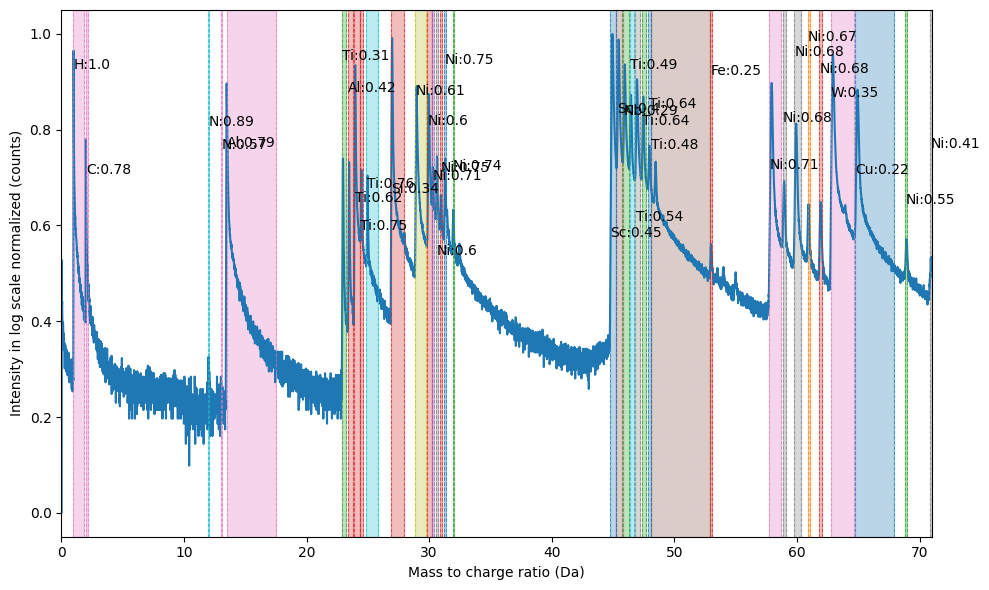

In [3]:
# Load in an .apt file and run both the ranging and ion classification models,
# then plot the results. This block uses Jingrui's NN model

# Update the path to the .apt file you want to use the models on
apt_file = 'drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt'

peak_range_pred, counts = predict_peak_ranges(apt_file, conf=0.05, iou=0.01, max_det=2000)

res, confidence, profile_final = predict_peak_ions_NN(apt_file, peak_range_pred, bin_width=0.01, max_width_Da=0.5)

#plot_predictions(apt_file, peak_range_pred, res, confidence, plot_min=0, plot_max=2000, resort=True)

plot_predictions_NEW(apt_file=apt_file,
                 peak_range_pred=peak_range_pred,
                 res=res,
                 confidence=confidence,
                 plot_min=0,
                 plot_max=7100,
                 resort=True)


# Run the peak detection and RF ion classifier together

In [4]:
# Need to git clone peak_detection_extra to get large RF model file
!git clone https://github.com/uw-cmg/peak_detection_extra

Cloning into 'peak_detection_extra'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 20 (delta 4), reused 15 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 6.87 MiB | 12.34 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Filtering content: 100% (4/4), 687.85 MiB | 30.77 MiB/s, done.


INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


Start inference
Speed:  123.4ms inference, 9.7ms postprocess for per spectrum 
model predicted peaks: 36
(36, 15)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


[[ 2.88720455e+01  5.58996424e-02  1.00000000e+00  4.22932476e-01
   1.22986570e-01  7.56815150e-02  7.36197457e-02 -1.00000000e+07
  -1.00000000e+07 -1.00000000e+07 -1.00000000e+07 -1.00000000e+07
  -1.00000000e+07 -1.00000000e+07 -1.00000000e+07]
 [ 5.88201370e+01  5.70572615e-02  1.00000000e+00  9.88008916e-01
   1.11693121e-01 -1.00000000e+07 -1.00000000e+07 -1.00000000e+07
  -1.00000000e+07 -1.00000000e+07 -1.00000000e+07 -1.00000000e+07
  -1.00000000e+07 -1.00000000e+07 -1.00000000e+07]
 [ 5.77286911e+01  5.77497445e-02  1.01213658e+00  1.00000000e+00
  -1.00000000e+07 -1.00000000e+07 -1.00000000e+07 -1.00000000e+07
  -1.00000000e+07 -1.00000000e+07 -1.00000000e+07 -1.00000000e+07
  -1.00000000e+07 -1.00000000e+07 -1.00000000e+07]
 [ 4.80819817e+01  5.78042492e-02  1.00000000e+00  1.37129873e-01
   1.31879777e-01  7.42123574e-02  7.15924203e-02 -1.00000000e+07
  -1.00000000e+07 -1.00000000e+07 -1.00000000e+07 -1.00000000e+07
  -1.00000000e+07 -1.00000000e+07 -1.00000000e+07]
 [ 3

<Figure size 640x480 with 0 Axes>

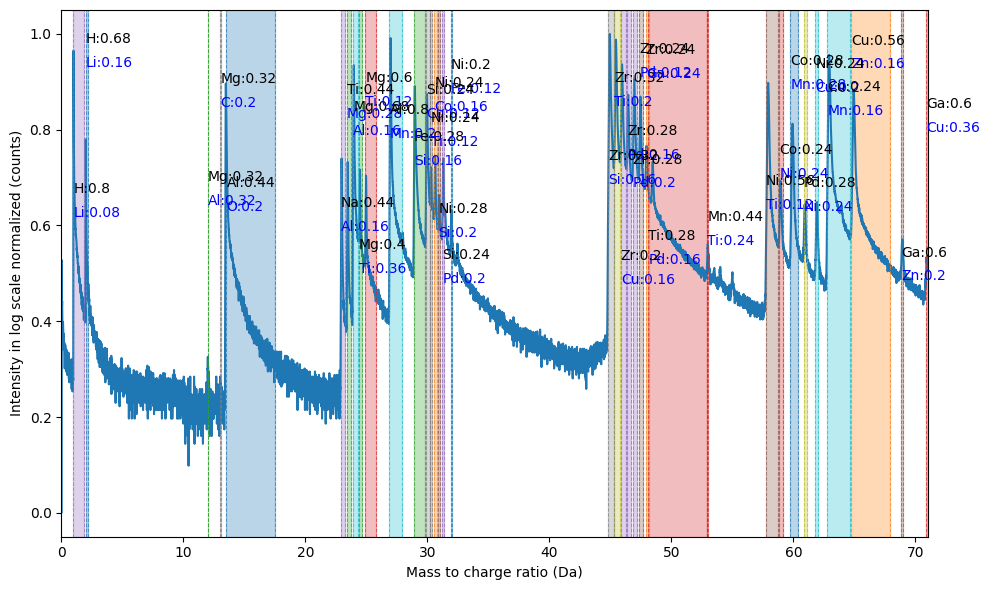

In [17]:
# Load in an .apt file and run both the ranging and ion classification models,
# then plot the results. This block uses in-development Random forest model

# Update the path to the .apt file you want to use the models on
apt_file = 'drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt'

peak_range_pred, counts = predict_peak_ranges(apt_file, conf=0.05, iou=0.01, max_det=2000)

elements, second_elements, confs, second_confs = predict_peak_ions_RF(peak_range_pred,
                                                                      counts,
                                                                      model_name='reducedset_peakneighbors2')

plot_predictions_NEW(apt_file=apt_file,
                 peak_range_pred=peak_range_pred,
                 res=elements,
                 confidence=confs,
                 plot_min=0,
                 plot_max=7100,
                 resort=False,
                 res2=second_elements,
                 confidence2=second_confs)

# Run evaluation over all files for both models


In [54]:

apt_files = ['drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt',]
              #'drive/MyDrive/Cameca/data_from_David/R15_72243.apt',
             #'drive/MyDrive/Cameca/data_from_David/R40_110290-v01 AuAlloy.apt',
              #'drive/MyDrive/Cameca/data_from_David/R79_172968 Al.apt',
              #'drive/MyDrive/Cameca/data_from_David/R6025_267386_NMC811_M04 example analysis.apt']

rrng_files = ['drive/MyDrive/Cameca/data_from_David/R13_40310Zr Top Level ROI.RRNG',]
              #'drive/MyDrive/Cameca/data_from_David/R15_72243 Top Level ROI.RRNG',
             # 'drive/MyDrive/Cameca/data_from_David/R40_110290Au.RRNG',
              #'drive/MyDrive/Cameca/data_from_David/R79_172968 Al Top Level ROI.RRNG',
             # 'drive/MyDrive/Cameca/data_from_David/R6025_267386_NMC811.RRNG']

for apt_file, rrng in zip(apt_files, rrng_files):
    results = dict()
    print('**************************')
    print('ANALYZING FILE', apt_file, rrng)
    print('**************************')
    rng = apav.load_rrng(rrng)

    # Get peak ranges
    peak_range_pred, counts = predict_peak_ranges(apt_file, conf=0.05, iou=0.01, max_det=2000)

    # Do Jingrui NN classification
    elements_sort, confidence, profile_final = predict_peak_ions_NN(apt_file, peak_range_pred, bin_width=0.01, max_width_Da=0.5)

    # Sort preds. For NN, the elements are already sorted
    peak_range_pred_sort = peak_range_pred[peak_range_pred[:, 0].argsort()]
    #peak_range_pred_sort, elements_sort = sort_predictions(peak_range_pred, res)
    elements_sort2 = ['NaN' for i in elements_sort]

    # Evaluate preds
    prec, recall, f1, acc_NN, acc_NN_nomol, is_found, true_found_elements, true_start, true_end, true_elements = evaluate_predictions(rng, peak_range_pred_sort, elements_sort, elements_sort2)

    print('Peak finding results')
    print(prec, recall, f1)

    results['Peak range true value, start'] = true_start
    results['Peak range true value, end'] = true_end
    results['Peak found?'] = is_found
    results['True ions found'] = true_found_elements

    results['Peak find precision'] = [prec]
    results['Peak find recall'] = [recall]
    results['Peak find F1'] = [f1]

    results['Peak range prediction, start'] = peak_range_pred_sort[:,0]
    results['Peak range prediction, end'] = peak_range_pred_sort[:,1]
    results['Peak range prediction, counts'] = counts
    results['Ion classification (Jingrui NN)'] = elements_sort
    results['Ion classification confidence (Jingrui NN)'] = confidence

    results['Ion classification accuracy (Jingrui NN)'] = [acc_NN]
    results['Ion classification accuracy without molecules (Jingrui NN)'] = [acc_NN_nomol]

    # Do RF classification
    peak_range_pred_sort = peak_range_pred[peak_range_pred[:, 0].argsort()]
    counts_sort = counts[peak_range_pred[:, 0].argsort()]
    elements, second_elements, confs, second_confs = predict_peak_ions_RF(peak_range_pred_sort, counts_sort, model_name='reducedset') #_peakneighbors2
    #elements, second_elements, confs, second_confs = predict_peak_ions_RF(peak_range_pred, counts, model_name='reducedset_peakneighbors5') #_peakneighbors2

    # Sort preds
    #peak_range_pred_sort, elements_sort = sort_predictions(peak_range_pred, elements)
    #peak_range_pred_sort, elements_sort2 = sort_predictions(peak_range_pred, second_elements)
    elements_sort = elements
    elements_sort2 = second_elements

    # Evaluate preds
    prec, recall, f1, acc_RF, acc_RF_nomol, is_found, true_found_elements, true_start, true_end, true_elements = evaluate_predictions(rng, peak_range_pred_sort, elements_sort, elements_sort2)

    results['Ion classification (Random forest)'] = elements_sort
    results['Ion classification confidence (Random forest)'] = confs
    results['Ion classification 2nd choice (Random forest)'] = elements_sort2
    results['Ion classification 2nd choice confidence (Random forest)'] = second_confs
    results['Ion classification accuracy (Random forest)'] = [acc_RF]
    results['Ion classification accuracy without molecules (Random forest)'] = [acc_RF_nomol]

    print('Jingrui NN Ion classification results')
    print(acc_NN, acc_NN_nomol)

    print('Random Forest Ion classification results')
    print(acc_RF, acc_RF_nomol)

    results_df = pd.DataFrame().from_dict(results, orient='index').T
    results_df.to_csv(apt_file.split('/')[-1]+'_results.csv', index=False)



INFO:apav:Reading RRNG file: drive/MyDrive/Cameca/data_from_David/R13_40310Zr Top Level ROI.RRNG
INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


**************************
ANALYZING FILE drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt drive/MyDrive/Cameca/data_from_David/R13_40310Zr Top Level ROI.RRNG
**************************
Start inference
Speed:  75.5ms inference, 5.2ms postprocess for per spectrum 


INFO:apav:Reading apt file: drive/MyDrive/Cameca/R13_40310Zr Unsaved - Top Level ROI.apt


model predicted peaks: 36
Peak finding results
0.9166666666666666 0.9705882352941176 0.9428571428571428
(36, 2)
[[9.5675719e-01 8.0648169e-02]
 [1.9923990e+00 6.9150311e-01]
 [1.1994313e+01 1.9297683e-01]
 [1.3021035e+01 1.1762461e-01]
 [1.3516728e+01 1.9204037e-01]
 [2.2899876e+01 6.9866478e-01]
 [2.3388010e+01 9.8497927e-02]
 [2.3899117e+01 3.7395114e-01]
 [2.4364084e+01 8.4710665e-02]
 [2.4890566e+01 6.8486530e-01]
 [2.6885298e+01 1.3217156e-01]
 [2.8872046e+01 5.5899642e-02]
 [2.9858757e+01 4.5451826e-01]
 [3.0246752e+01 7.3861688e-01]
 [3.0573769e+01 7.5930232e-01]
 [3.0891645e+01 1.5212110e-01]
 [3.1230978e+01 2.6707560e-01]
 [3.1912558e+01 6.5931804e-02]
 [4.4777203e+01 4.5152730e-01]
 [4.5272644e+01 1.3785458e-01]
 [4.5830101e+01 7.9218650e-01]
 [4.6380974e+01 4.2152920e-01]
 [4.6813721e+01 4.3831018e-01]
 [4.7336845e+01 7.7890331e-01]
 [4.7880867e+01 8.0740738e-01]
 [4.8081982e+01 5.7804249e-02]
 [5.2920975e+01 8.0893770e-02]
 [5.7728691e+01 5.7749745e-02]
 [5.8820137e+01 5.70

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.6.1. This might lead to b

In [55]:
#for i, j, l, k in zip(peak_range_pred_sort*0.01, elements, second_elements, true_elements):
for i, j, l, k in zip(peak_range_pred_sort*0.01, elements_sort, elements_sort2, true_elements):

  print(i, j, l, k)

tensor([0.9568, 1.8408]) H NaN H
tensor([1.9924, 2.1567]) H NaN H2
tensor([11.9943, 12.0545]) Mg C Al
tensor([13.0210, 13.0725]) Mg Al Al
tensor([13.5167, 17.5184]) Al NaN Ti
tensor([22.8999, 23.2390]) Na NaN Ti
tensor([23.3880, 23.7533]) Ti Sc Ti
tensor([23.8991, 24.3431]) Mg Ti Ti
tensor([24.3641, 24.6395]) Ti Mg Ti
tensor([24.8906, 25.7970]) Mg Ti Ni
tensor([26.8853, 27.9101]) Al NaN Ni
tensor([28.8720, 29.7683]) Ni Co Ni
tensor([29.8588, 30.2156]) Co Ni Ni
tensor([30.2468, 30.4006]) Co Ni Ni
tensor([30.5738, 30.7568]) Co Ni Ni
tensor([30.8916, 31.0374]) Cu Ni Zr
tensor([31.2310, 31.3785]) Cu Ni Zr
tensor([31.9126, 32.0279]) Zn Cu Zr
tensor([44.7772, 45.2771]) Zr Ti Zr
tensor([45.2726, 45.7567]) Zr Sc Zr
tensor([45.8301, 46.2831]) Sc Zr Zr
tensor([46.3810, 46.7091]) Sc Zr Zr
tensor([46.8137, 47.1920]) Ti Sc Zr
tensor([47.3368, 47.7018]) Sc Zr Zr
tensor([47.8809, 48.1308]) Zr Sc HZr
tensor([48.0820, 52.8780]) Ti Zr HZr
tensor([52.9210, 53.0316]) Pd Ti HZr
tensor([57.7287, 58.7121]) N